<a href="https://colab.research.google.com/github/NathanDoumeche/fast-kernel/blob/main/fast_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install cufinufft==2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 MB 2.0 MB/s eta 0:00:00


In [2]:
import torch
import cupy as cp
import cufinufft
import numpy as np


In [3]:
device = torch.device("cuda:0")
torch.set_default_dtype(torch.float64)

# 1- Sobolev regression

In [4]:
def conjugate_gradient(A_function, b, x0, tol=1e-10):
    """
    Solves Ax = b using the Conjugate Gradient method.

    Parameters:
        A : function or matrix
            Matrix or function that computes the product Ax.
        b : ndarray
            Right-hand side vector.
        x0 : ndarray
            Initial guess.
        tol : float
            Tolerance for the stopping criterion.
        max_iter : int
            Maximum number of iterations.

    Returns:
        x : ndarray
            Approximate solution to Ax = b.
    """
    m = b.shape[0]

    x = x0
    r = b - A_function(x)
    p = r.clone()
    rs_old = torch.linalg.vector_norm(r)**2

    for i in range(m):
        Ap = A_function(p)
        alpha = rs_old / torch.vdot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = torch.linalg.vector_norm(r)**2

        if torch.sqrt(rs_new) < tol:
            print(f"CG converged in {i} iterations.")
            break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new

    return x

In [5]:
def circulant_col(toeplitz_col, device):

  n = toeplitz_col.shape[0]

  # Create Hermitian-symmetric circulant embedding

  circulant_vector = torch.concatenate([
      toeplitz_col,
      torch.zeros(n-1, device=device),
      torch.conj(torch.flip(toeplitz_col[1:], (0,)))
  ])
  return circulant_vector, n

def fast_hermitian_toeplitz_mv(circulant, n, x, device):
    # Zero-pad x
    x_padded = torch.concatenate([x, torch.zeros(2 * n-2 , device=device)])

    # FFT-based convolution (complex)
    fft_c = torch.fft.fft(circulant)
    fft_x = torch.fft.fft(x_padded)

    y = torch.fft.ifft(fft_c * fft_x)[:n]

    return y  # complex-valued result

In [6]:
def kernel_vect(x_gpu, N, threshold):
  n = x_gpu.shape[0]
  y_gpu = cp.ones(n).astype(cp.complex128)

  f_gpu = cufinufft.nufft1d1(x_gpu, y_gpu, (2*N,), eps=threshold)[N:]/n
  f_tensor = torch.utils.dlpack.from_dlpack(f_gpu)

  circulant, n = circulant_col(f_tensor, device)
  return circulant

In [7]:
def S_vect_inv(m, s):
  frequencies =  torch.arange(-m, m+1, device=device)
  return 1/(1 + torch.abs(frequencies)**s)

def A_function(x, lambda_n, S_inv, k_circ):
  n = x.shape[0]
  kernel_term = S_inv* fast_hermitian_toeplitz_mv(k_circ, n, S_inv * x, device)
  return kernel_term + lambda_n * x

In [8]:
def NUFFT_Y(x_gpu, y_gpu, m, threshold):
  n = x_gpu.shape[0]

  f_gpu = cufinufft.nufft1d1(x_gpu, y_gpu, (2*m+1,), eps=threshold)/n

  f_tensor = torch.utils.dlpack.from_dlpack(f_gpu)

  return f_tensor

In [9]:
def FFT_inv(x_gpu, nufft, m, lambda_n, threshold):
    k_vect = kernel_vect(x_gpu, 2*m+1, threshold)
    S_inv = S_vect_inv(m, s)
    A_funct = lambda x: A_function(x, lambda_n, S_inv, k_vect)

    x0 = nufft.clone()
    inv = conjugate_gradient(A_funct, nufft, x0, tol=threshold)
    print("Error CG ", torch.linalg.norm(A_funct(inv) - nufft))
    return S_inv * inv

In [10]:
def NUFFT_inv(x_gpu, f_gpu, N, threshold):
  n = x_gpu.shape[0]

  y_estimated = cufinufft.nufft1d2(x_gpu, f_gpu, eps=threshold)

  y_estimated = torch.utils.dlpack.from_dlpack(y_estimated)

  return y_estimated

In [34]:
err_N, list_N = np.array([]), np.array([])

for i in range(1, 17):
  N = int(10**(i/2))
  threshold = 10e-15
  x_gpu =  cp.random.uniform(size=N).astype(cp.float64)
  y_gpu =  cp.exp(x_gpu).astype(cp.complex128) + cp.random.normal(size=N).astype(cp.complex128)


  s,d = 1,1
  lambda_n=N**(-(2*s)/(2*s+d))
  m = int(N**(1/(2*s+d))) #int(np.sqrt(N))

  S_inv = S_vect_inv(m, s)

  cov_y = S_inv*NUFFT_Y(x_gpu, y_gpu, m, threshold)
  hat_theta = FFT_inv(x_gpu, cov_y, m, lambda_n, threshold)

  N_test = 10**4
  x_test = cp.random.uniform(size=N_test).astype(cp.float64)
  y_test = cp.exp(x_test).astype(cp.complex128)

  estimator = torch.real(NUFFT_inv(x_test, hat_theta, m, threshold))

  error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
  mse = torch.mean(torch.square(torch.abs(error)))

  list_N = np.append(list_N, N)
  err_N = np.append(err_N, mse)


CG converged in 2 iterations.
Error CG  tensor(3.8205e-15, device='cuda:0')
Error CG  tensor(3.0652e-13, device='cuda:0')
CG converged in 6 iterations.
Error CG  tensor(7.9118e-16, device='cuda:0')
CG converged in 6 iterations.
Error CG  tensor(3.4881e-15, device='cuda:0')
CG converged in 8 iterations.
Error CG  tensor(1.3953e-15, device='cuda:0')
CG converged in 9 iterations.
Error CG  tensor(3.2697e-15, device='cuda:0')
CG converged in 14 iterations.
Error CG  tensor(5.8853e-16, device='cuda:0')
CG converged in 17 iterations.
Error CG  tensor(4.3631e-15, device='cuda:0')
CG converged in 24 iterations.
Error CG  tensor(1.0523e-15, device='cuda:0')
CG converged in 35 iterations.
Error CG  tensor(2.6564e-15, device='cuda:0')
CG converged in 50 iterations.
Error CG  tensor(8.4324e-16, device='cuda:0')
CG converged in 76 iterations.
Error CG  tensor(6.0726e-15, device='cuda:0')
CG converged in 117 iterations.
Error CG  tensor(2.7115e-15, device='cuda:0')
CG converged in 165 iterations.
Er

Text(0, 0.5, 'MSE')

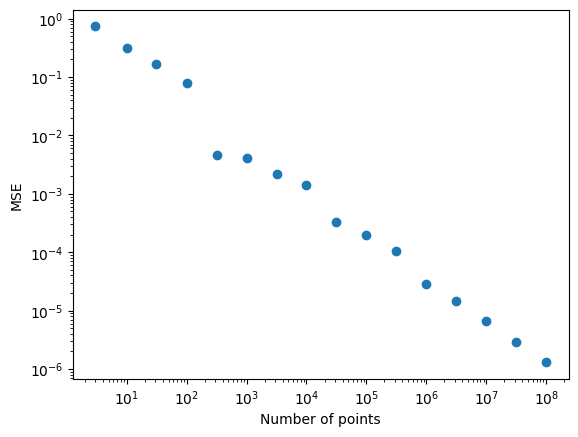

In [35]:
import matplotlib.pyplot as plt

plt.scatter(list_N, err_N)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("MSE")

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


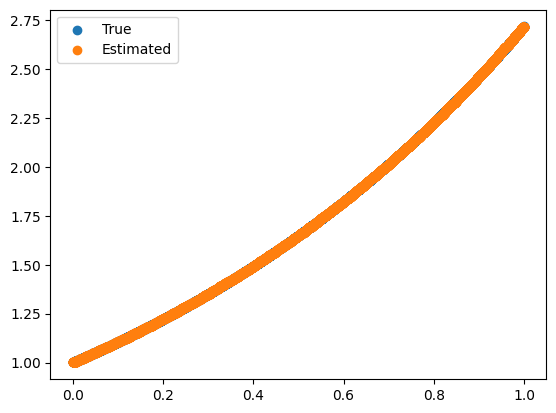

In [23]:
import matplotlib.pyplot as plt

plt.scatter(x_test.get(), y_test.get(), label="True")
plt.scatter(x_test.get(), estimator.cpu().numpy(), label="Estimated")
plt.legend()
plt.show()

## 1.2- High values of n

In [36]:
def FFT_inv_k(k_vect, nufft, m, lambda_n, threshold):
    S_inv = S_vect_inv(m, s)
    A_funct = lambda x: A_function(x, lambda_n, S_inv, k_vect)

    x0 = nufft.clone()
    inv = conjugate_gradient(A_funct, nufft, x0, tol=threshold)
    print("Error CG ", torch.linalg.norm(A_funct(inv) - nufft))
    return S_inv * inv

In [37]:
N_batch = 10**8

for iterations in [3, 10, 30, 100]:
  N_tot = N_batch*iterations

  threshold = 10e-15
  s,d = 1,1
  lambda_n=N_tot**(-(2*s)/(2*s+d))
  m = int(N_tot**(1/(2*s+d)))

  cov_y = torch.zeros(2*m+1, device=device)*(1.+0*1j)

  for i in range(iterations):

    x_gpu =  cp.random.uniform(size=N_batch).astype(cp.float64)
    y_gpu =  cp.exp(x_gpu).astype(cp.complex128) + cp.random.normal(size=N_batch).astype(cp.complex128)

    S_inv = S_vect_inv(m, s)

    cov_y += S_inv*NUFFT_Y(x_gpu, y_gpu, m, threshold)

    if i==0:
      k_vect = kernel_vect(x_gpu, 2*m+1, threshold)
    else:
      k_vect += kernel_vect(x_gpu, 2*m+1, threshold)

    print("Batch ", i, "/", iterations)

  cov_y /= iterations
  k_vect /= iterations

  hat_theta = FFT_inv_k(k_vect, cov_y, m, lambda_n, threshold)

  N_test = 10**4
  x_test = cp.random.uniform(size=N_test).astype(cp.float64)
  y_test = cp.exp(x_test).astype(cp.complex128)

  estimator = torch.real(NUFFT_inv(x_test, hat_theta, m, threshold))

  error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
  mse = torch.mean(torch.square(torch.abs(error)))

  list_N = np.append(list_N, N_tot)
  err_N = np.append(err_N, mse)


Batch  0 / 3
Batch  1 / 3
Batch  2 / 3
CG converged in 442 iterations.
Error CG  tensor(9.0348e-15, device='cuda:0')
Batch  0 / 10
Batch  1 / 10
Batch  2 / 10
Batch  3 / 10
Batch  4 / 10
Batch  5 / 10
Batch  6 / 10
Batch  7 / 10
Batch  8 / 10
Batch  9 / 10
CG converged in 649 iterations.
Error CG  tensor(8.2268e-15, device='cuda:0')
Batch  0 / 30
Batch  1 / 30
Batch  2 / 30
Batch  3 / 30
Batch  4 / 30
Batch  5 / 30
Batch  6 / 30
Batch  7 / 30
Batch  8 / 30
Batch  9 / 30
Batch  10 / 30
Batch  11 / 30
Batch  12 / 30
Batch  13 / 30
Batch  14 / 30
Batch  15 / 30
Batch  16 / 30
Batch  17 / 30
Batch  18 / 30
Batch  19 / 30
Batch  20 / 30
Batch  21 / 30
Batch  22 / 30
Batch  23 / 30
Batch  24 / 30
Batch  25 / 30
Batch  26 / 30
Batch  27 / 30
Batch  28 / 30
Batch  29 / 30
CG converged in 961 iterations.
Error CG  tensor(9.0519e-15, device='cuda:0')
Batch  0 / 100
Batch  1 / 100
Batch  2 / 100
Batch  3 / 100
Batch  4 / 100
Batch  5 / 100
Batch  6 / 100
Batch  7 / 100
Batch  8 / 100
Batch  9 / 1

Text(0, 0.5, 'MSE')

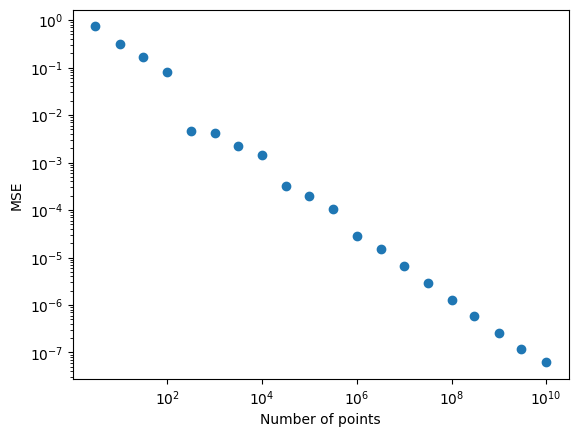

In [38]:
import matplotlib.pyplot as plt

plt.scatter(list_N, err_N)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("MSE")

# 2- PIKL

In [24]:
def PDE_vect(m):
  frequencies =  torch.arange(-m, m+1, device=device)
  return 1 + 1j*frequencies

def A_function_PIKL(x, lambda_n, mu, S_inv, PDE_vector, k_circ):
  n = x.shape[0]
  kernel_term = S_inv* fast_hermitian_toeplitz_mv(k_circ, n, S_inv * x, device)
  PDE_term = torch.conj_physical(PDE_vector)*S_inv* fast_hermitian_toeplitz_mv(k_circ, n, PDE_vector*S_inv * x, device)
  return kernel_term + lambda_n * x + mu * PDE_term

def FFT_inv_PIKL(x_gpu, nufft, m, lambda_n, mu, threshold):
    k_vect = kernel_vect(x_gpu, 2*m+1, threshold)
    S_inv = S_vect_inv(m, s)
    PDE_vector = PDE_vect(m)
    A_funct = lambda x: A_function_PIKL(x, lambda_n, mu, S_inv, PDE_vector, k_vect)

    x0 = nufft.clone()
    inv = conjugate_gradient(A_funct, nufft, x0, tol=threshold)
    print("Error CG ", torch.linalg.norm(A_funct(inv) - nufft))
    return S_inv * inv

In [25]:
err_N_PIKL, list_N_PIKL = np.array([]), np.array([])

for i in range(1, 17):
  N = int(10**(i/2))
  threshold = 10e-15
  x_gpu =  cp.random.uniform(size=N).astype(cp.float64)
  y_gpu =  cp.exp(x_gpu).astype(cp.complex128) + cp.random.normal(size=N).astype(cp.complex128)


  s,d = 1,1
  lambda_n=1/N/10#N**(-(2*s)/(2*s+d))
  mu = 1
  m = int(N**(1/(2*s+d))) #int(np.sqrt(N))

  S_inv = S_vect_inv(m, s)

  cov_y = S_inv*NUFFT_Y(x_gpu, y_gpu, m, threshold)
  hat_theta = FFT_inv_PIKL(x_gpu, cov_y, m, lambda_n, mu, threshold)

  N_test = 10**4
  x_test = cp.random.uniform(size=N_test).astype(cp.float64)
  y_test = cp.exp(x_test).astype(cp.complex128)

  estimator = torch.real(NUFFT_inv(x_test, hat_theta, m, threshold))

  error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
  mse = torch.mean(torch.square(torch.abs(error)))

  list_N_PIKL = np.append(list_N_PIKL, N)
  err_N_PIKL = np.append(err_N_PIKL, mse)

Error CG  tensor(2.7402e-13, device='cuda:0')
Error CG  tensor(1.3448e-08, device='cuda:0')
Error CG  tensor(2.1695e-10, device='cuda:0')
Error CG  tensor(2.3073e-09, device='cuda:0')
Error CG  tensor(2.5786e-10, device='cuda:0')
Error CG  tensor(8.8284e-12, device='cuda:0')
CG converged in 28 iterations.
Error CG  tensor(6.3457e-15, device='cuda:0')
CG converged in 37 iterations.
Error CG  tensor(5.8461e-15, device='cuda:0')
Error CG  tensor(3.3487e-12, device='cuda:0')
CG converged in 76 iterations.
Error CG  tensor(5.4202e-15, device='cuda:0')
CG converged in 98 iterations.
Error CG  tensor(4.4560e-15, device='cuda:0')
CG converged in 128 iterations.
Error CG  tensor(4.3323e-15, device='cuda:0')
CG converged in 167 iterations.
Error CG  tensor(7.5175e-15, device='cuda:0')
CG converged in 207 iterations.
Error CG  tensor(1.2076e-14, device='cuda:0')
CG converged in 356 iterations.
Error CG  tensor(1.0822e-14, device='cuda:0')
CG converged in 422 iterations.
Error CG  tensor(8.4297e-1

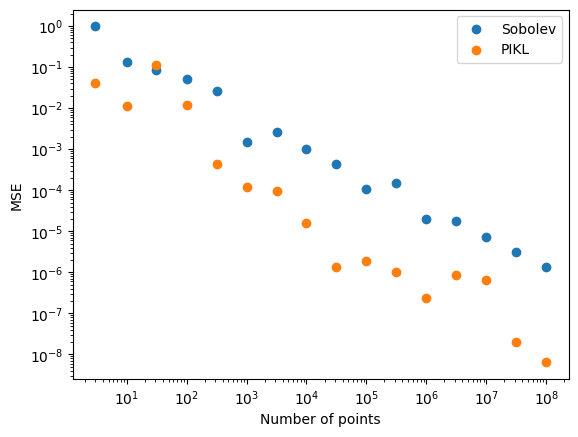

In [26]:
import matplotlib.pyplot as plt

plt.scatter(list_N, err_N, label="Sobolev")
plt.scatter(list_N_PIKL, err_N_PIKL, label="PIKL")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("MSE")
plt.legend()